In [283]:
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import re


# Compiling all files into one


In [284]:
df_list = []
for file in os.listdir("files"):
    df = pd.read_csv(f"files/{file}",skiprows=[0,1,2,3],sep = ";") #Skip the first 3 rows as it is not needed
    df_list.append(df)




In [285]:
#This is where I make the combined .csv files into one main file
df_list = []
for file in os.listdir("files"):
    df = pd.read_csv(f"files/{file}",skiprows=[0,1,2,3],sep = ";") #Skip the first 3 rows as it is not needed
    df_list.append(df)

for i in range(len(df_list)):
    df = df.append(df_list[i])


df.to_csv('final.csv')



# Cleaning The Data

In [286]:
df_cleaned = df.copy()
#Make df_copy with changed column names
df_cleaned.rename(columns = {"Bedrijf": "Country Id", 
                     "Dossiernummer": "Order ID",
                     "Vertrekdatum": "Departure Date", 
                     "Bedrag": "Amount", 
                     "Boekingstype": "Category",
                     "Ticket uitgifte datum": "Ticket Issuance Date", 
                     "Luchtvaartmaatschappij": "Airline Code",
                     "Boekingskanaal": "Booking Channel",
                     "Sub-kanaal": "Booking Sub-Channel", 
                     "Einddatum segment": "Date of Last Segment", 
                     "Nieuw/Wijziging/Annulering": "New/Changed/Cancelled", 
                     "Eindbestemming vlucht": "Destination"},inplace = True)

In [287]:
#Replace European Format to decimal format
df_cleaned["Amount"] = df_cleaned["Amount"].str.replace('.', '').str.replace(',', '.').astype(float)

/var/folders/5z/hd4vckwj3db3x0dppmgvprjm0000gn/T/ipykernel_81737/3771504840.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_cleaned["Amount"] = df_cleaned["Amount"].str.replace('.', '').str.replace(',', '.').astype(float)


In [288]:
#Make sure to drop any duplicates
df_cleaned.drop_duplicates(inplace = True)

In [289]:
#Convert Departure Date, issuance date to datetime
df_cleaned["Departure Date"] = pd.to_datetime(df_cleaned["Departure Date"], format="%d-%m-%Y")
df_cleaned["Ticket Issuance Date"] = pd.to_datetime(df_cleaned["Ticket Issuance Date"], format="%d-%m-%Y")

In [290]:
#Create where changed or cancelled
#Where W = changed and A = Cancelled
df_cleaned = df_cleaned[(df_cleaned["New/Changed/Cancelled"] == "A") |  (df_cleaned["New/Changed/Cancelled"] == "W")]

In [291]:
#Drop na
df_cleaned = df_cleaned.dropna(subset=['Airline Code', 'Ticket Issuance Date'])

In [299]:
#Filter the dates
start_date = "14-12-2013"
end_date = "13-01-2014"

filtered_df_departure = df_cleaned[(df_cleaned['Departure Date'] >= start_date) & (df_cleaned['Departure Date'] <= end_date)]


filtered_df_issuance = df_cleaned[(df_cleaned['Ticket Issuance Date'] >= start_date) & (df_cleaned['Ticket Issuance Date'] <= end_date)]





Departure Date
2013-12-14    28
2013-12-15    13
2013-12-16    19
2013-12-17    37
2013-12-18    35
2013-12-19    38
2013-12-20    60
2013-12-21    44
2013-12-22    42
2013-12-23    43
2013-12-24    30
2013-12-25    54
2013-12-26    48
2013-12-27    50
2013-12-28    47
2013-12-29    41
2013-12-30    42
2013-12-31    28
2014-01-01    39
2014-01-02    30
2014-01-03    34
2014-01-04    18
2014-01-05    31
2014-01-06    20
2014-01-07    24
2014-01-08    22
2014-01-09    25
2014-01-10    24
2014-01-11    21
2014-01-12    33
2014-01-13    16
dtype: int64

In [274]:
#Filter by most changed/cancelled destination
filtered_dates.groupby(["Destination"]).size().sort_values(ascending = False)

Destination
BKK    47
AGP    32
AMS    31
BCN    30
LIS    23
       ..
DTW     1
CGP     1
CHC     1
MBJ     1
ELQ     1
Length: 233, dtype: int64

In [275]:
#Filter by issuance dates

filtered_df_issuance.groupby(["Ticket Issuance Date"]).size().sort_values(ascending = True)

Ticket Issuance Date
2014-01-13     4
2014-01-11     7
2013-12-22     9
2014-01-12    12
2013-12-25    12
2014-01-10    13
2013-12-21    15
2013-12-28    16
2013-12-26    16
2013-12-19    17
2013-12-14    24
2013-12-29    24
2013-12-30    25
2013-12-24    26
2013-12-20    28
2013-12-27    28
2013-12-23    31
2013-12-31    33
2014-01-04    35
2014-01-08    38
2013-12-15    38
2014-01-01    39
2014-01-07    41
2014-01-09    41
2014-01-02    42
2014-01-05    42
2013-12-16    44
2014-01-03    46
2014-01-06    58
2013-12-17    59
2013-12-18    64
dtype: int64

In [276]:
#Filter by departure date
filtered_df_departure.groupby(["Departure Date"]).size().sort_values(ascending = False)

Departure Date
2013-12-20    60
2013-12-25    54
2013-12-27    50
2013-12-26    48
2013-12-28    47
2013-12-21    44
2013-12-23    43
2013-12-30    42
2013-12-22    42
2013-12-29    41
2014-01-01    39
2013-12-19    38
2013-12-17    37
2013-12-18    35
2014-01-03    34
2014-01-12    33
2014-01-05    31
2013-12-24    30
2014-01-02    30
2013-12-14    28
2013-12-31    28
2014-01-09    25
2014-01-07    24
2014-01-10    24
2014-01-08    22
2014-01-11    21
2014-01-06    20
2013-12-16    19
2014-01-04    18
2014-01-13    16
2013-12-15    13
dtype: int64

In [277]:
#Filter by price
filtered_dates.groupby(["Amount"]).size().sort_values(ascending = False)

Amount
 0.00       706
 4696.00      4
 21.00        3
 200.00       3
 38.00        2
           ... 
-187.00       1
-175.54       1
-174.24       1
-162.40       1
 8489.00      1
Length: 200, dtype: int64

# Data Analysis/Visualization

## Plotting amount of cancelled and changed by issuance date and departure date

In [300]:
filtered_df_issuance = filtered_df_issuance.groupby(["Ticket Issuance Date"]).size()
filtered_df_departure = filtered_df_departure.groupby(["Departure Date"]).size()


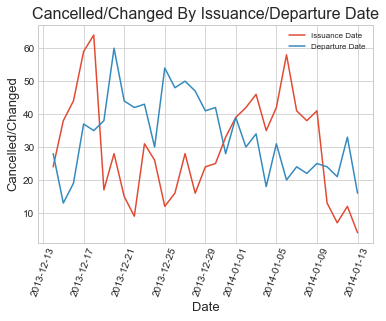

In [305]:
plt.style.use('seaborn-whitegrid')


plt.title("Cancelled/Changed By Issuance/Departure Date",fontsize=16)
plt.xlabel("Date",fontsize=13)
plt.xticks(rotation=70)
plt.ylabel("Cancelled/Changed",fontsize=13)


plt.plot(filtered_df_issuance,label = 'Issuance Date')
plt.plot(filtered_df_departure,label = 'Departure Date')
plt.legend(fontsize=8)
plt.show()


## Plotting cancelled and changed by airlines

In [281]:
filtered_dates[["Airline Code"]]

,Airline Code
279,UA
280,UA
596,OS
597,OS
760,SU
...,...
1581,W6
1917,XQ
2126,OS
2261,RJ


<AxesSubplot:xlabel='Airline Code'>

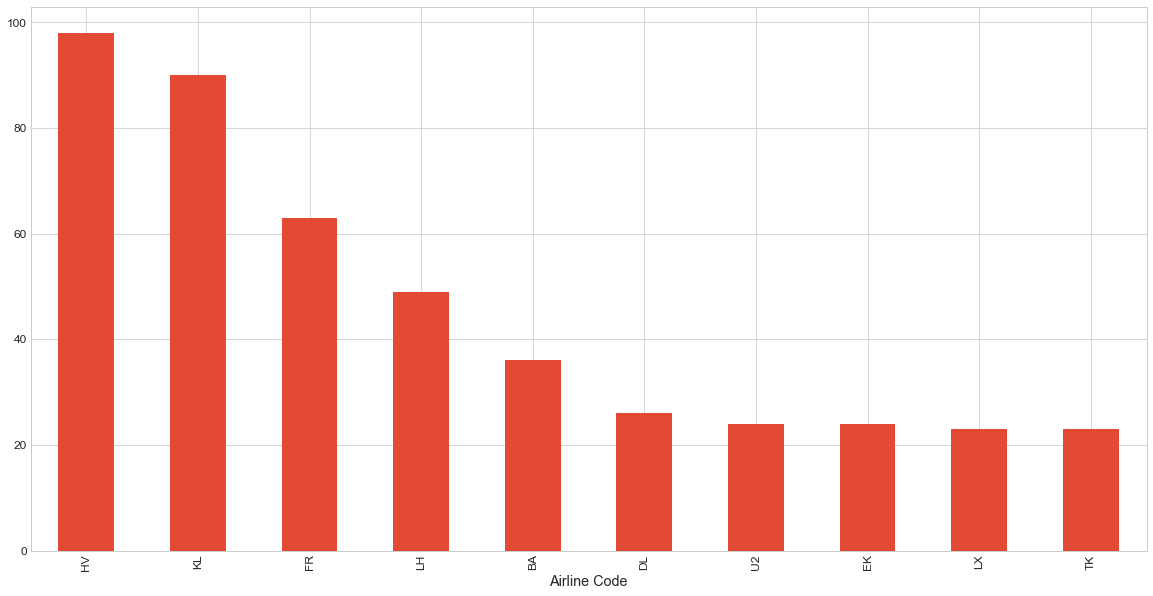

In [282]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 10))

#Top ten cancelled/changed tickets
codes = filtered_dates.groupby(["Airline Code"]).size().sort_values(ascending = False).head(10)
codes.plot.bar()


In [1329]:
filtered_dates.groupby(["Airline Code"]).size().sort_values(ascending = False).head(10)

Airline Code
HV    98
KL    90
FR    63
LH    49
BA    36
DL    26
EK    24
U2    24
LX    23
TK    23
dtype: int64

## Ten most cancelled/changed airlines

In [103]:
filtered_dates.groupby(["Airline Code"]).size().sort_values(ascending = False).head(10)

Airline Code
HV    98
KL    90
FR    63
LH    49
BA    36
DL    26
U2    24
EK    24
LX    23
TK    23
dtype: int64

## Ten least cancelled/changed airlines

In [104]:
filtered_dates.groupby(["Airline Code"]).size().sort_values(ascending = False).tail(10)

Airline Code
DY    1
DE    1
CM    1
CA    1
BR    1
BJ    1
AV    1
AK    1
5H    1
XQ    1
dtype: int64

## Benefit/Loss from cancelled/changed

In [105]:
#Change "Amount" to floats
filtered_dates["Amount"] = filtered_dates["Amount"].astype("float")

/var/folders/5z/hd4vckwj3db3x0dppmgvprjm0000gn/T/ipykernel_81737/2656225077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dates["Amount"] = filtered_dates["Amount"].astype("float")


In [106]:
#Total Benefit
total_benefit = filtered_dates[filtered_dates["Amount"] >= 0]["Amount"].sum().round(2) 
total_benefit

62506.47

In [107]:
#Total Loss
total_loss = filtered_dates[filtered_dates["Amount"] < 0]["Amount"].sum().round(2) 
total_loss

-401788.16

In [108]:
#Total Benefit/Loss from cancelled/changed
filtered_dates["Amount"].round().sum()

-339281.0

In [109]:
#Mean Benefit/Loss from cancelled/changed flights

round((filtered_dates["Amount"]).mean(),2)

-366.0

## Top 5 benefits by airlines

In [110]:
#Top 5 benefits
top_5_benefits = filtered_dates.sort_values(by ="Amount",ascending = False).head(5)
top_5_benefits

,Country Id,Order ID,Departure Date,Amount,Category,Product type,Ticket nummer,Ticket Issuance Date,PNR nummer,Ticket route,Airline Code,Booking Channel,Booking Sub-Channel,Date of Last Segment,New/Changed/Cancelled,Destination
1855,33,1972,2013-12-20,8489.00,FLIGHT,Vliegticket,"5,89434E+12",2013-12-14,59NVEHM,MAA/TRZ,9W,NaN,NaN,20-12-2013,A,TRZ
2866,33,1975,2013-12-17,7673.00,FLIGHT,Vliegticket,"9,8434E+11",2013-12-14,6AHKSQM,BOM/JDH,AI,NaN,NaN,17-12-2013,W,JDH
1934,32,18311,2014-01-03,5866.87,FLIGHT,Vliegticket,"1,95464E+12",2013-12-20,Y29RMTM,LED/KRR,FV,NaN,NaN,3-1-2014,W,KRR
2431,32,18395,2013-12-25,5540.00,FLIGHT,Vliegticket,67353607844,2013-12-24,ZUZL9EM,LED/AMS/CDG/SLC/ONT/SEA/AMS/LE,DL,NaN,NaN,20-1-2014,W,ONT
3312,33,2023,2013-12-29,4696.00,FLIGHT,Vliegticket,A7T23CLM004,2013-12-17,7T23CLM,COK/TRZ,9W,NaN,NaN,29-12-2013,A,TRZ


[]

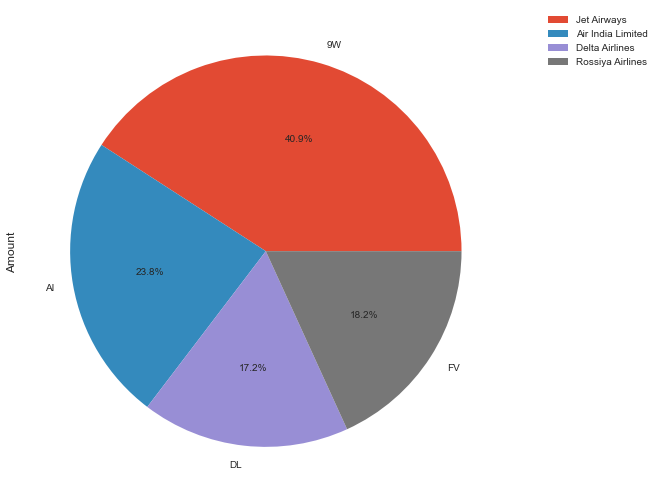

In [308]:
benefits = top_5_benefits[["Airline Code", "Amount"]].groupby(["Airline Code"]).sum()
benefits.plot.pie(y = "Amount",autopct='%1.1f%%',figsize=(11, 9))
plt.legend(loc="upper right", bbox_to_anchor=(1.3,1),labels=["Jet Airways",
                                                            "Air India Limited",
                                                            "Delta Airlines",
                                                            "Rossiya Airlines"])
#Put the plot away from the TM_datafiles
plt.savefig("gain_plot.png")
plt.plot()




## Top 5 loss by airlines

In [309]:
#Top 5 loss
top_5_loss = filtered_dates.sort_values(by ="Amount",ascending = True).head(5)
#Change the amount to positive in order to put in pie graph
top_5_loss["Amount"] = top_5_loss["Amount"]*-1
top_5_loss

,Country Id,Order ID,Departure Date,Amount,Category,Product type,Ticket nummer,Ticket Issuance Date,PNR nummer,Ticket route,Airline Code,Booking Channel,Booking Sub-Channel,Date of Last Segment,New/Changed/Cancelled,Destination
4073,33,2072,2013-12-31,134717.81,FLIGHT,Vliegticket,"9,84341E+11",2013-12-23,ZT2QH4M,DEL/ORD,AI,Skyscanner bua in,YxQxTmtyEeOM1gBQVrwMkQ,31-12-2013,W,ORD
4060,33,1995,2014-01-01,65259.93,FLIGHT,Vliegticket,"1,25434E+12",2013-12-16,6SDUL3M,DEL/LHR/YYZ,BA,Ixigo bua.in,DIR---IN-FO-DEL-YTO-A-BABA.408b8acc33dd441896,1-1-2014,W,YYZ
2474,32,17864,2014-01-06,39152.45,FLIGHT,Vliegticket,"6,70463E+12",2013-12-15,53IQM6M,JFK/LAX/***/VKO/JFK/***/LAX/LH,UN,skyscannerru bua.ru,fHwXJmR7EeOv8wBQVpAoHw,22-1-2014,A,LAX
3507,32,18823,2014-01-02,26284.00,FLIGHT,Vliegticket,"7,74634E+11",2014-01-01,5AMGFLM,DME/CAI/SSH/CAI/DME,MS,momondo bua.ru,NaN,9-1-2014,A,SSH
3948,32,17899,2014-03-25,22563.20,FLIGHT,Vliegticket,"5,55438E+12",2013-12-15,6GXJ4JM,UUD/SVO/TLV/SVO/UUD,SU,NaN,NaN,7-4-2014,A,TLV


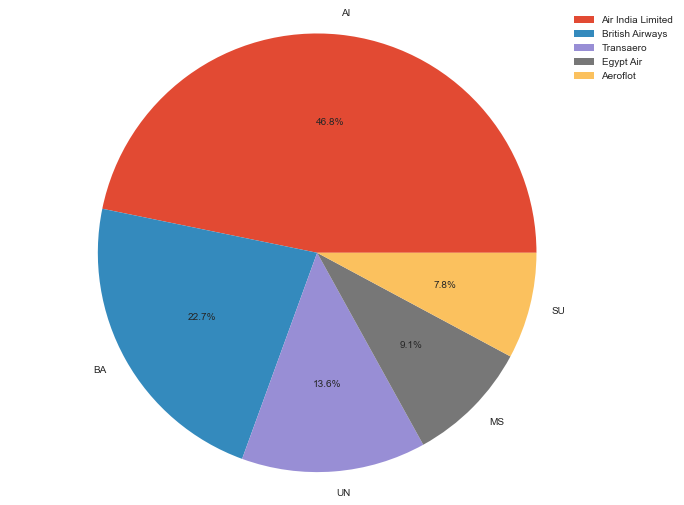

In [312]:

plt.figure(figsize = (11,9))
plt.pie(top_5_loss["Amount"], labels = top_5_loss["Airline Code"],autopct='%1.1f%%')
plt.legend(loc="upper right", bbox_to_anchor=(1.1,1),labels=["Air India Limited",
                                                            "British Airways",
                                                            "Transaero",
                                                            "Egypt Air",
                                                            "Aeroflot"])

plt.axis('equal')

#Put the plot away from the TM_datafiles
plt.savefig("loss_plot.png")

plt.show()
